In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model
import os
from google.colab import drive
import zipfile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import csv
import time
import matplotlib.gridspec as gridspec

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
  from thop import profile, clever_format
except:
    print("[INFO] Couldn't find thop... installing it.")
    !pip install thop
    from thop import profile, clever_format

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find thop... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(f"[INFO] Using {torch.cuda.get_device_name(0)}")
else:
    print("[INFO] Using CPU")

[INFO] Using Tesla V100-SXM2-16GB


In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/final_evaluation'
file_dir = '/content/final_evaluation'

#Upload train data folder to google colab files directory
if not os.path.exists(file_dir):
  os.makedirs(file_dir)
  zip_train= zipfile.ZipFile(os.path.join(folder_path, 'test_image.zip'), 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

Total number of  data : 5007
{'0': 500, '1': 501, '2': 501, '3': 501, '4': 501, '5': 501, '6': 500, '7': 501, '8': 500, '9': 501}


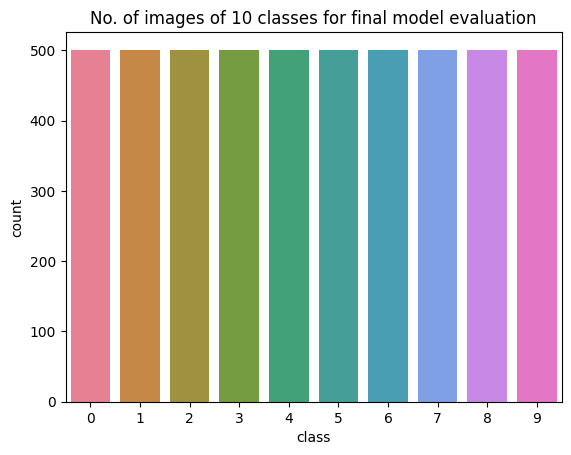

In [6]:
front_data_path = "/content/final_evaluation/test_image/front_RGB"
side_data_path = "/content/final_evaluation/test_image/side_RGB"

classes = [c for c in os.listdir(front_data_path) if not c.startswith(".")]
classes.sort()
num_classes = len(classes)
d = {"img" : [], "class" : []}
data_count = {}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(front_data_path,c)) if not img.startswith(".")]
    data_count[c] = len(imgs)
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="No. of images of 10 classes for final model evaluation")
print("Total number of  data :",len(df))
print(data_count)

In [7]:
class_dict = {0 : "safe driving",
              1 : "drinking",
              2 : "talking on the phone - left",
              3 : "talking on the phone - right",
              4 : "texting - left",
              5 : "texting - right",
              6 : "Doing hair",
              7 : "Adjusting specs",
              8 : "Reaching behind",
              9 : "Sleeping"}

#Evaluation of refined SAM-DDD MobileNetV3 Large (Front View) Model

In [7]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

front_test_data = datasets.ImageFolder(root = front_data_path, transform = transform)

5007


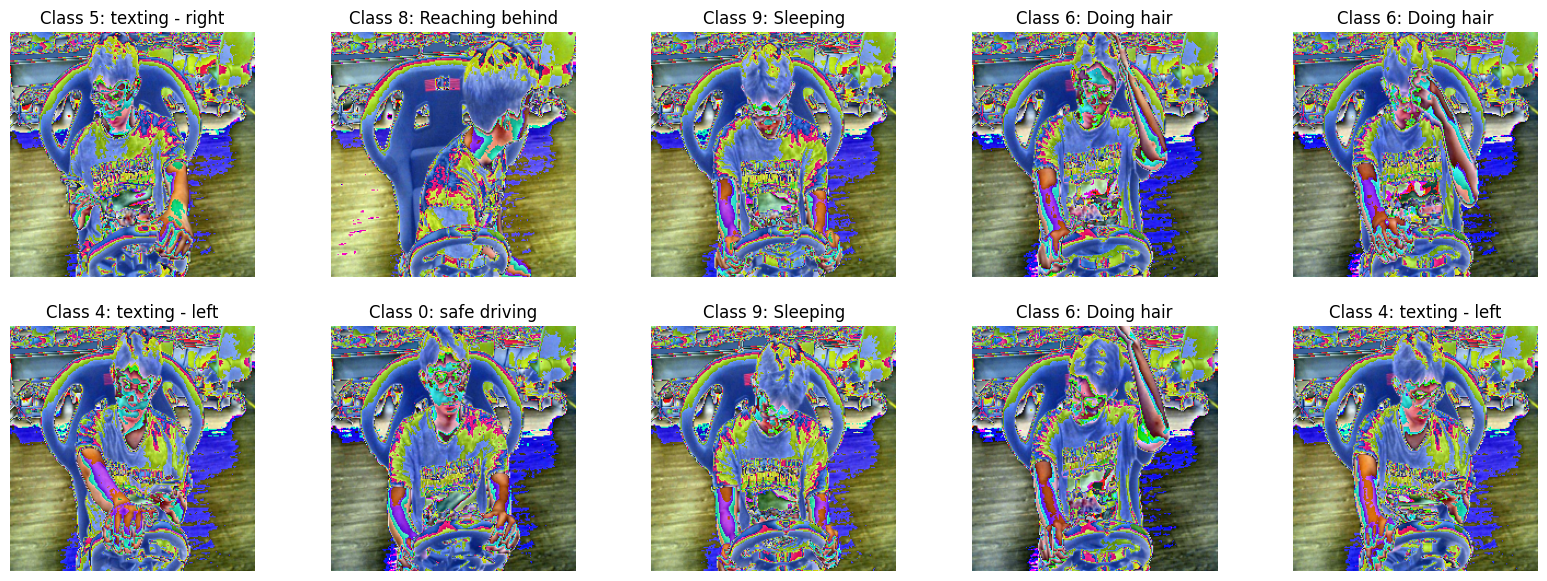

In [10]:
total_data = len(front_test_data)
print(total_data)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))  # Adjust as needed for layout
axes = axes.flatten()

for i in range (10):
  idx = np.random.randint(total_data)
  image, label = front_test_data[idx]
  # Convert the tensor image back to a PIL Image for displaying
  image_pil = transforms.ToPILImage()(image)

  axes[i].imshow(image_pil)
  axes[i].axis('off')  # Don't show axes for clarity
  axes[i].set_title(f"Class {label}: {class_dict[label]}")  # Optional: Display the label

In [11]:
batch_size = 16
front_data_loader = torch.utils.data.DataLoader(front_test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_feature = model.classifier[0].in_features
output_shape = num_classes

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_feature, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_shape)
)

log_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/training_log/front_refined_all'
checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

# Move the model to the device
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [14]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [15]:
input, label = next(iter(front_data_loader))
input = input.to(device)
flops, params = profile(model, inputs=(input, ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


In [16]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0
num_misclassified = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
all_true_labels = []
images_to_display = []

model.eval()
with torch.no_grad():
    for X_test, y_test in front_data_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true_labels.extend(y_test.cpu().numpy())
        images_to_display.extend(X_test.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frames Per Second (FPS): {int(total_data / total_time)} seconds")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")
print(f"Number of misclassified images: {num_misclassified}")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    idx = np.random.randint(0, len(all_preds_np))
    image = images_to_display[idx].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Actual: {class_dict[all_true_labels[idx]]}\nPred: {class_dict[all_preds[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

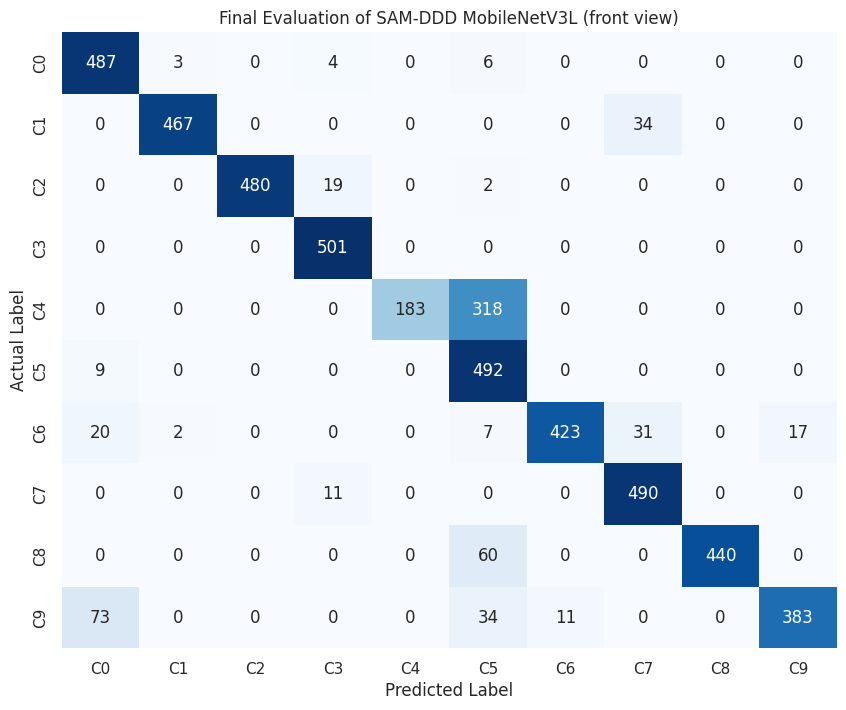

In [18]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Final Evaluation of SAM-DDD MobileNetV3L (front view)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

save_path = os.path.join(folder_path, 'MobileNetV3L(front)/final_evaluation_performance')
os.makedirs(save_path, exist_ok=True)

result_path = os.path.join(save_path, 'model_predictions.csv')
metrics_path = os.path.join(save_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

In [21]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)

In [22]:
# Base directories for saving images
correct_dir = os.path.join(folder_path, "MobileNetV3L(front)/classified_images/correct")
misclassified_dir = os.path.join(folder_path, "MobileNetV3L(front)/classified_images/misclassified")
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(misclassified_dir, exist_ok=True)

In [24]:
for i, (image_np, pred, true_label) in enumerate(zip(images_to_display, all_preds, all_true_labels)):
    image = image_np.transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    image_pil = Image.fromarray(image)

    # Determine if the classification is correct
    is_correct = (pred == true_label)
    save_path = correct_dir if is_correct else misclassified_dir

    # Define the directory based on the true label
    label_dir = os.path.join(save_path, str(true_label))
    os.makedirs(label_dir, exist_ok=True)

    # Save the image
    image_file = os.path.join(label_dir, f"image_actual{true_label}_pred{pred}_{i}.jpg")
    image_pil.save(image_file)

#Evaluation of refined SAM-DDD MobileNetV3 Large (Side View) Model

In [25]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

side_test_data = datasets.ImageFolder(root = side_data_path, transform = transform)

In [26]:
total_data = len(side_test_data)
print(total_data)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))  # Adjust as needed for layout
axes = axes.flatten()

for i in range (10):
  idx = np.random.randint(total_data)
  image, label = side_test_data[idx]
  # Convert the tensor image back to a PIL Image for displaying
  image_pil = transforms.ToPILImage()(image)

  axes[i].imshow(image_pil)
  axes[i].axis('off')  # Don't show axes for clarity
  axes[i].set_title(f"Class {label}: {class_dict[label]}")  # Optional: Display the label

Output hidden; open in https://colab.research.google.com to view.

In [27]:
batch_size = 16
side_data_loader = torch.utils.data.DataLoader(side_test_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [28]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_feature = model.classifier[0].in_features
output_shape = num_classes

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_feature, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_shape)
)

log_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/training_log/side_refined_all'
checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

# Move the model to the device
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [29]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [30]:
input, label = next(iter(side_data_loader))
input = input.to(device)
flops, params = profile(model, inputs=(input, ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


In [31]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0
num_misclassified = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
all_true_labels = []
images_to_display = []

model.eval()
with torch.no_grad():
    for X_test, y_test in side_data_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true_labels.extend(y_test.cpu().numpy())
        images_to_display.extend(X_test.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frames Per Second (FPS): {int(total_data / total_time)} seconds")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")
print(f"Number of misclassified images: {num_misclassified}")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    idx = np.random.randint(0, len(all_preds_np))
    image = images_to_display[idx].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Actual: {class_dict[all_true_labels[idx]]}\nPred: {class_dict[all_preds[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

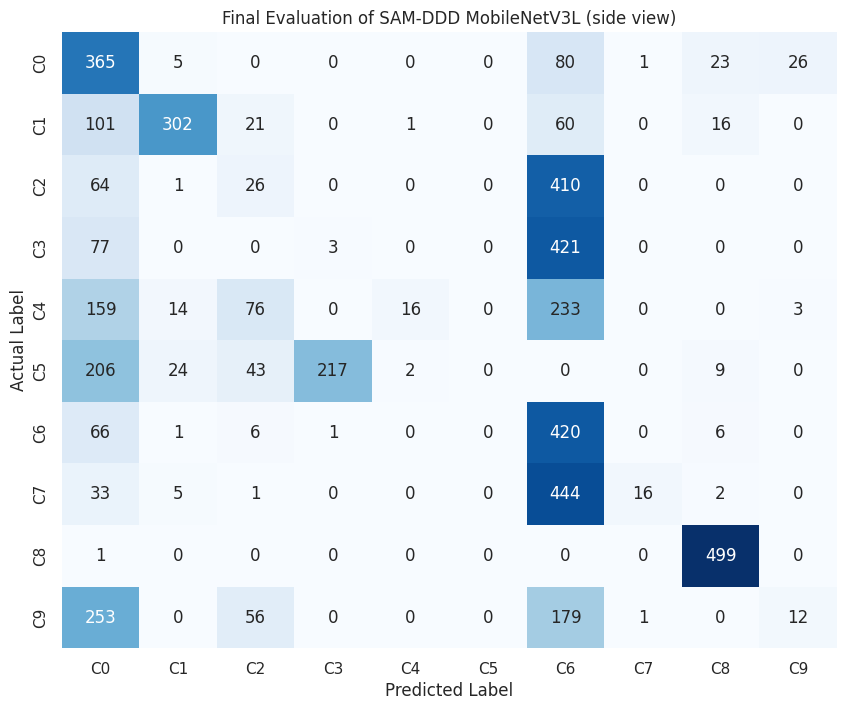

In [33]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Final Evaluation of SAM-DDD MobileNetV3L (side view)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [34]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

save_path = os.path.join(folder_path, 'MobileNetV3L(side)/final_evaluation_performance')
os.makedirs(save_path, exist_ok=True)

result_path = os.path.join(save_path, 'model_predictions.csv')
metrics_path = os.path.join(save_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Frames Per Second (FPS): {int(total_data / total_time)} seconds")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

In [35]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)

In [36]:
# Base directories for saving images
correct_dir = os.path.join(folder_path, "MobileNetV3L(side)/classified_images/correct")
misclassified_dir = os.path.join(folder_path, "MobileNetV3L(side)/classified_images/misclassified")
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(misclassified_dir, exist_ok=True)

In [37]:
for i, (image_np, pred, true_label) in enumerate(zip(images_to_display, all_preds, all_true_labels)):
    image = image_np.transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    image_pil = Image.fromarray(image)

    # Determine if the classification is correct
    is_correct = (pred == true_label)
    save_path = correct_dir if is_correct else misclassified_dir

    # Define the directory based on the true label
    label_dir = os.path.join(save_path, str(true_label))
    os.makedirs(label_dir, exist_ok=True)

    # Save the image
    image_file = os.path.join(label_dir, f"image_actual{true_label}_pred{pred}_{i}.jpg")
    image_pil.save(image_file)

#Evaluation of refined SAM-DDD dual-stream MobileNetV3 Large Model (Front and Side View)

In [8]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("PairedDriverDataset", "/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD/TwoStreamPairedDataset.py")
paired_driver_dataset_module  = importlib.util.module_from_spec(spec)
spec.loader.exec_module(paired_driver_dataset_module)
PairedDriverDataset = paired_driver_dataset_module.PairedDriverDataset

In [9]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

data = PairedDriverDataset(
    front_dir = front_data_path,
    side_dir = side_data_path,
    file_type = 'eval',
    transform = transform
)


In [10]:
num_pairs = 20
fig, axs = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))

for i in range(num_pairs):
  idx = np.random.randint(0, len(data))  # Random index
  front_image, side_image, class_idx = data[idx]  # Fetch images and class index

  # Convert tensors back to PIL images for display purposes
  # Skip these lines if your transform does not convert images to tensors
  front_image = transforms.ToPILImage()(front_image)
  side_image = transforms.ToPILImage()(side_image)

  class_name = class_dict[class_idx]

  # Plot front image
  axs[i, 0].imshow(front_image)
  axs[i, 0].set_title(f"Front View {i}: {class_name}")
  axs[i, 0].axis('off')

  # Plot side image
  axs[i, 1].imshow(side_image)
  axs[i, 1].set_title(f"Side View {i}: {class_name}")
  axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [11]:
batch_size = 16
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
front_folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/training_log/front_refined_all'
side_folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/training_log/side_refined_all'

model_path1 = os.path.join(front_folder_path, 'my_checkpoint.pth.tar')
model_path2 = os.path.join(side_folder_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    front_checkpoint = torch.load(model_path1)
    side_checkpoint = torch.load(model_path2)



In [13]:
spec = importlib.util.spec_from_file_location("TwoStreamMobileNetV3L", "/content/drive/MyDrive/DAR_Deep Learning Model/TwoStreamMobileNetV3L.py")
TwoStreamMobileNetV3L = importlib.util.module_from_spec(spec)
sys.modules["TwoStreamMobileNetV3L"] = TwoStreamMobileNetV3L
spec.loader.exec_module(TwoStreamMobileNetV3L)

In [14]:
model = None

if model == None:
  model = TwoStreamMobileNetV3L.TwoStreamMobileNetV3L(front_checkpoint, side_checkpoint)

load_path = "/content/drive/MyDrive/DAR_Deep Learning Model/evaluation/training_log/dual_refined_all"

checkpoint_path = os.path.join(load_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

for param in model.classifier.parameters():
    param.requires_grad = False

# Load the model state
model.load_state_dict(checkpoint['state_dict'])



# Move the model to the device
model.to(device)

TwoStreamMobileNetV3L(
  (model1): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNorm

In [45]:
summary(model=model,
        input_size=[(16, 3, 224, 224), (16, 3, 224, 224)],  # Corrected typo from 244 to 224
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TwoStreamMobileNetV3L (TwoStreamMobileNetV3L)                     [16, 3, 224, 224]    [16, 10]             --                   False
├─MobileNetV3 (model1)                                            --                   --                   1,242,890            False
│    └─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (464)                False
│    │    └─InvertedResidual (2)                                  [16, 16, 112, 112]   [16, 24, 56, 56]     (3,440)              False
│    │    └─InvertedResidual (3)                   

In [15]:
front_input, side_input, label = next(iter(data_loader))
front_input = front_input.to(device)
side_input = side_input.to(device)
flops, params = profile(model, inputs=(front_input, side_input ))
macs, params = clever_format([flops, params], "%.3f")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


Total inference time for the entire dataset is 32.1651 seconds
Frame per second (FPS): 155
Floating Point Operations Per Second (FLOPS): 747.0 M
Precision: 88.99%
Recall: 81.09%
Test accuracy: 81.09%
F1 Score: 80.16%
Number of misclassified images: 947


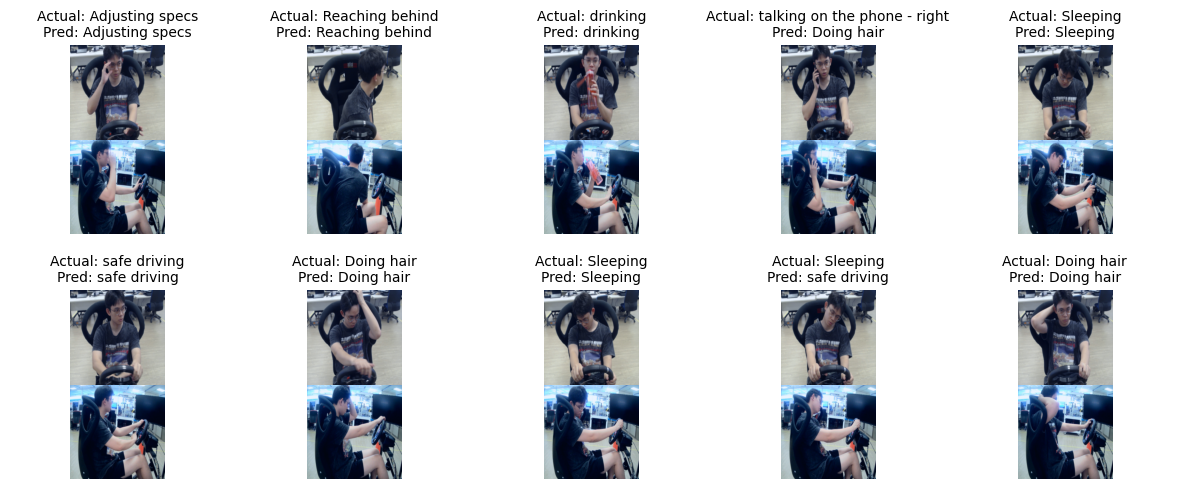

In [18]:
# Parameters for visualization
num_pairs_to_display = 10
images_to_display = []
images_per_row = 5  # 5 pairs per row, but each pair has 2 images
total_images = len(data)
num_misclassified = 0

# Prepare the figure for visualization
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(int(np.ceil(num_pairs_to_display*2 / images_per_row)), images_per_row, figure=fig, hspace=0.3, wspace=0.1)


# Start the timer
start_time = time.time()

#Prediction phase
all_preds = []
all_true_labels = []
# Lists to collect data for visualization (indices or references)
data_for_visualization = []

model.eval()
with torch.no_grad():
    for i, (X1_test, X2_test, y_test) in enumerate(data_loader):
        X1_test = X1_test.to(device)
        X2_test = X2_test.to(device)
        y_test = y_test.to(device)

        test_pred = model(X1_test, X2_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        actual = y_test.cpu().numpy()
        all_true_labels.extend(actual)

        # Collect data for visualization
        for j in range(X1_test.size(0)):
          data_for_visualization.append((X1_test[j], X2_test[j], actual[j], preds[j]))

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

for pred, true_label in zip(all_preds, all_true_labels):
    if pred != true_label:
        num_misclassified += 1

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)

# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frame per second (FPS): {int(total_images/total_time)}")
print(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")
print(f"Number of misclassified images: {num_misclassified}")

for i, (X1, X2, actual, pred) in enumerate(data_for_visualization):
    if i >= num_pairs_to_display:
        break

    image1 = X1.cpu().numpy().transpose((1, 2, 0))
    image2 = X2.cpu().numpy().transpose((1, 2, 0))

    # Normalize images for visualization
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())

    row = (i // images_per_row)
    col = i % images_per_row

    # Create a subplot for the pair
    ax_pair = plt.Subplot(fig, gs[row, col])
    fig.add_subplot(ax_pair)
    ax_pair.axis('off')

    # Create an inset axis for each image within the pair
    ax1 = ax_pair.inset_axes([0, 0.5, 1, 0.5])  # Top image
    ax2 = ax_pair.inset_axes([0, 0, 1, 0.5])  # Bottom image

    # Adjust the vertical spacing between the images in a pair
    ax1.set_title(f"Actual: {class_dict.get(actual, 'Unknown')}\nPred: {class_dict.get(pred, 'Unknown')}", fontsize=10)
    ax1.imshow(image1)
    ax1.axis('off')

    ax2.imshow(image2)
    ax2.axis('off')

plt.show()

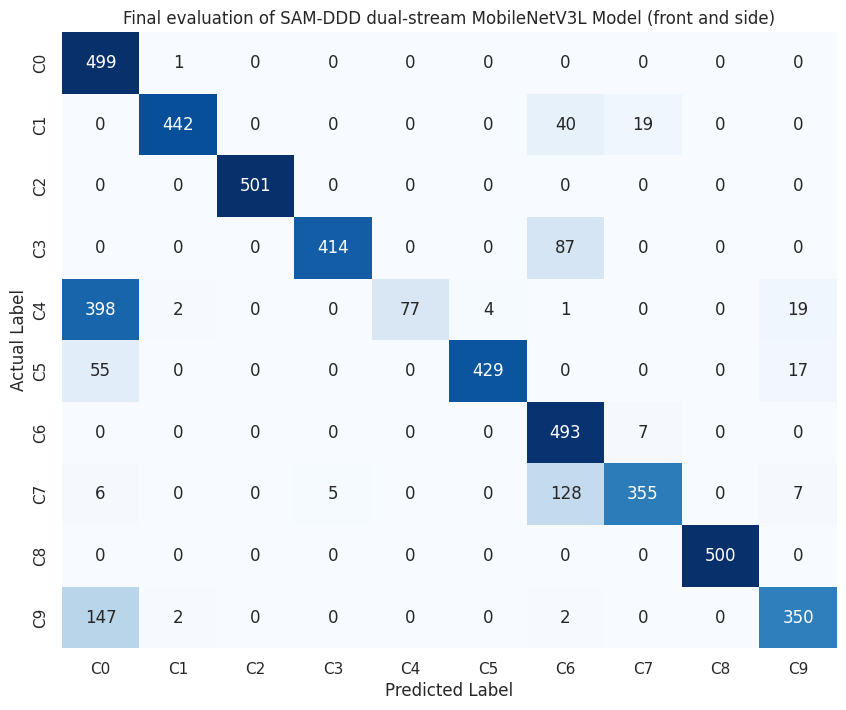

In [19]:
num_classes = len(class_dict)
class_labels = ['C' + str(i) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_str = np.array([["{0:.0f}".format(value) for value in row] for row in conf_matrix])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Final evaluation of SAM-DDD dual-stream MobileNetV3L Model (front and side)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

save_path = os.path.join(folder_path, 'Dual-stream MobileNetV3L/final_evaluation_performance')
os.makedirs(save_path, exist_ok=True)

result_path = os.path.join(save_path, 'model_predictions.csv')
metrics_path = os.path.join(save_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Frame per second (FPS): {int(total_images/total_time)}\n")
    f.write(f"Floating Point Operations Per Second (FLOPS): {flops//10e6} M\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")
    f.write(f"Number of misclassified images: {num_misclassified}")

In [21]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(save_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)

In [22]:
# Base directories for saving images
front_correct_dir = os.path.join(folder_path, "Dual-stream MobileNetV3L/classified_images/correct/front_RGB")
side_correct_dir = os.path.join(folder_path, "Dual-stream MobileNetV3L/classified_images/correct/side_RGB")
front_misclassified_dir = os.path.join(folder_path, "Dual-stream MobileNetV3L/classified_images/misclassified/front_RGB")
side_misclassified_dir = os.path.join(folder_path, "Dual-stream MobileNetV3L/classified_images/misclassified/side_RGB")
os.makedirs(front_correct_dir, exist_ok=True)
os.makedirs(side_correct_dir, exist_ok=True)
os.makedirs(front_misclassified_dir, exist_ok=True)
os.makedirs(side_misclassified_dir, exist_ok=True)

In [23]:
for i, (front_image_np, side_image_np, true_label, pred) in enumerate(data_for_visualization):
    front_image = front_image_np.cpu().numpy().transpose((1, 2, 0))
    front_image = (front_image - front_image.min()) / (front_image.max() - front_image.min())  # Normalize
    front_image = (front_image * 255).astype(np.uint8)  # Convert to uint8
    front_image_pil = Image.fromarray(front_image)

    side_image = side_image_np.cpu().numpy().transpose((1, 2, 0))
    side_image = (side_image - side_image.min()) / (side_image.max() - side_image.min())  # Normalize
    side_image = (side_image * 255).astype(np.uint8)  # Convert to uint8
    side_image_pil = Image.fromarray(side_image)

    # Determine if the classification is correct
    is_correct = (pred == true_label)
    front_save_path = front_correct_dir if is_correct else front_misclassified_dir
    side_save_path = side_correct_dir if is_correct else side_misclassified_dir

    # Define the directory based on the true label
    front_label_dir = os.path.join(front_save_path, str(true_label))
    side_label_dir = os.path.join(side_save_path, str(true_label))
    os.makedirs(front_label_dir, exist_ok=True)
    os.makedirs(side_label_dir, exist_ok=True)

    # Save the image
    front_image_file = os.path.join(front_label_dir, f"image_front_actual{true_label}_pred{pred}_{i}.jpg")
    side_image_file = os.path.join(side_label_dir, f"image_side_actual{true_label}_pred{pred}_{i}.jpg")
    front_image_pil.save(front_image_file)
    side_image_pil.save(side_image_file)